In [ ]:
!pip install -r requirements.txt

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import os
import glob
from datetime import datetime
import time
import cv2
import pandas as pd

import tensorflow as tf
print(tf.__version__)

from keras.applications import EfficientNetB0
from keras.models import Model, Sequential
from keras import layers
from keras import callbacks
#from keras.layers import Dense, Dropout, Input, GlobalAveragePooling2D, BatchNormalization
#from keras.optimizers import Adam, RMSprop

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import funcs as f

2.16.2


In [3]:
#from keras.callbacks import EarlyStopping
class CustomStopper(callbacks.EarlyStopping):
    def __init__(self, monitor='val_loss',
             patience=5, verbose=0, mode='auto', start_epoch = 10, restore_best_weights=True): # add argument for starting epoch
        super(CustomStopper, self).__init__()
        self.start_epoch = start_epoch

    def on_epoch_end(self, epoch, logs=None):
        if epoch > self.start_epoch:
            super().on_epoch_end(epoch, logs)

In [4]:
SIZE = 254 #Size of the images this model will deal with
IMDIM = 3
IMG_SIZE = (SIZE, SIZE)            # Define the image size
INPUT_SHAPE = (*IMG_SIZE, IMDIM)       # Define the input_shape

Filters = 16
BATCH_SIZE = 128
EPOCHS = 100
TEST_SIZE = 0.3   # Validation/Train split ratio

RAND_SEED  = 42 # The answer to the ultimate question of life, the universe, and everything

In [5]:
path = './branded/'
#os.system(f"aws s3 cp {'s3://open-logo-s3/branded/'} {path} --recursive")  

#### Read the file names and labeles

In [6]:
# this list holds all the image filename
boxes_file_paths = []
labels = []

# reads paths for each image and stores it in the array, also stores the label in a separate array
for path_tuple in os.walk(path):
    for file in path_tuple[2]:
        if file.endswith(".jpg"):
            boxes_file_paths.append(os.path.join(path_tuple[0], file))
            labels.append(path_tuple[0].split('/')[-1])

#### Prepare a dataframe of filenames and labels

In [7]:
# Convert labels to dataframe
lbl_df = pd.DataFrame(labels, columns=['label'])

# Get a new data frame with the counts of each lable
counts = lbl_df.groupby('label').value_counts().sort_values(ascending=False).to_frame()
counts['brand_name'] = counts.index

In [8]:
# Get the brand info from the datbase
import db_ops
query = f'''
SELECT *
FROM brand
ORDER BY brand_name DESC
'''
brand_df = db_ops.select_to_pandas(query, True, True)

Connecting to the PostgreSQL database...
Connection successful


/home/ubuntu/workspace/litter-imagery-brand-recognition/db_ops.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [9]:
counts = counts.set_index('brand_name').join(brand_df.set_index('brand_name')).sort_values('brand_name')
counts['idx'] = range(len(counts))

In [10]:
counts.to_csv('brand_ids_idx.csv', sep = '\t')
counts

,count,brand_id,score,idx
brand_name,,,,
100_grand,1,112,0.0,0
1800,2,113,0.0,1
3_musketeers,2,114,0.0,2
absolute,1,115,0.0,3
absopure,1,116,0.0,4
...,...,...,...,...
white_claw,7,300,0.0,219
york,1,301,0.0,220
zaxbys,1,302,0.0,221


In [11]:
# Associate uniqe numeric index with the brand and, consequently, the file
lbl_df['idx'] = lbl_df['label'].apply(lambda x: counts['idx'].loc[x])

# Add the path to the df
lbl_df['file_path'] = boxes_file_paths

# Shuffle the dataframe
lbl_df = lbl_df.sample(frac=1).reset_index(drop=True)
lbl_df

,label,idx,file_path
0,wawa,215,./branded/wawa/ordered_220_ordered_287_im.jpg9...
1,zz_unbranded,223,./branded/zz_unbranded/ordered_518_ordered_111...
2,corona,46,./branded/corona/im.jpg5764.jpg
3,marlboro,114,./branded/marlboro/im.jpg1717.jpg
4,zz_unbranded,223,./branded/zz_unbranded/ordered_657_ordered_524...
...,...,...,...
5277,mikes_hard,120,./branded/mikes_hard/ordered_1001_ordered_911_...
5278,zz_unbranded,223,./branded/zz_unbranded/ordered_1183_ordered_11...
5279,zz_unbranded,223,./branded/zz_unbranded/ordered_46_ordered_2294...
5280,corona,46,./branded/corona/im.jpg1531.jpg


In [12]:
# Set the number of categories
num_classes = len(counts)
num_classes

224

#### Read the files/labels and convert them into the right shape

In [13]:
# Make an array of the images
X = []
for file_path in lbl_df['file_path']:
    # Read the image
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)

    #Resize the image so that the smaller side is the right size
    h, w = img.shape[:2]
    if h > w:
        width = SIZE
        dim = (width, int(SIZE* h / w)) 
    else:
        height = SIZE
        dim = (int(SIZE* w/h), height)
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

    # Crop the image to a square of the target size
    h, w = img.shape[:2]
    if h > w:
        img = img[(h-w)//2:(h-w)//2 + w, :, :]
    else:
        img = img[:, (w-h)//2:(w-h)//2 + h, :]

    X.append(img)
X = np.array(X)
X.shape

# Get np array of labeles
y_dense = np.array(lbl_df['idx'])


y = to_categorical(y_dense, num_classes=num_classes)
y.shape

(5282, 224)

#### Read the labels

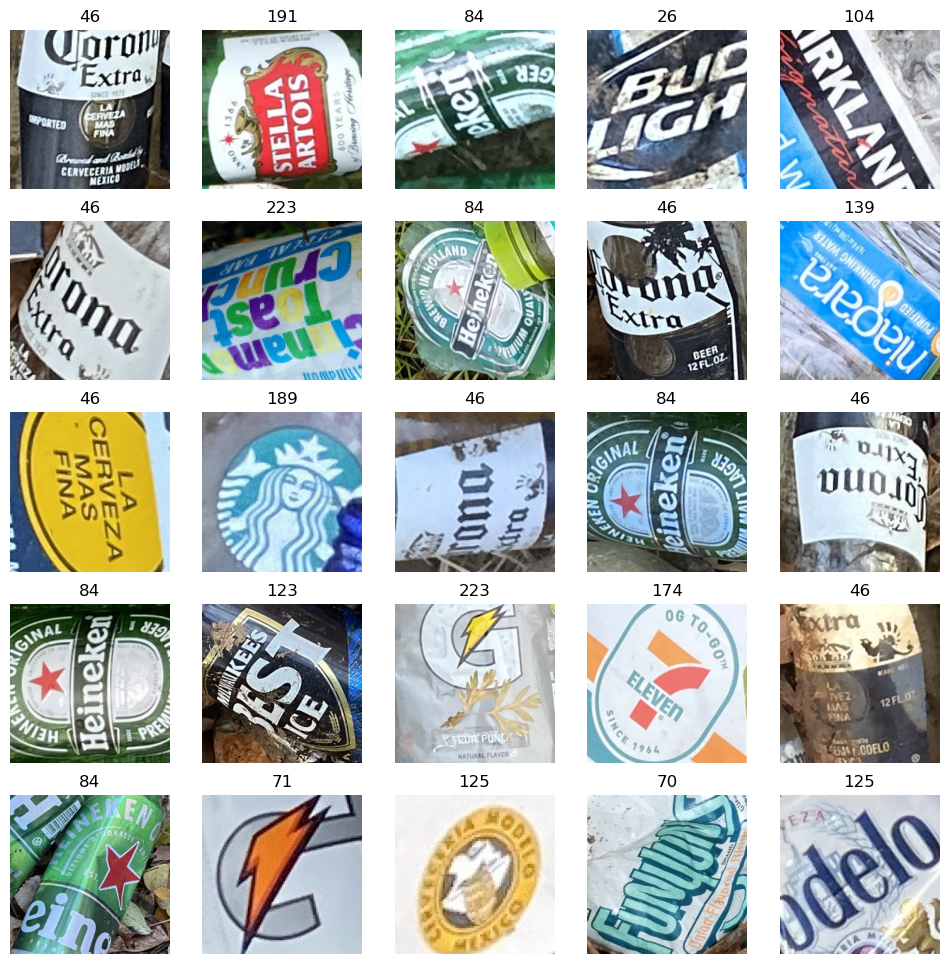

In [14]:
# Visualize random 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = np.random.choice(np.arange(len(y)))
    axs[i,j].imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
    axs[i,j].set_title(y_dense[idx])
    axs[i,j].axis('off')

plt.show()

# Make sure all images are square, undistorted, labels make sense

In [15]:
def build_model(num_classes):
    '''
    img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=1),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",)
    '''
    inputs = layers.Input(shape=INPUT_SHAPE)
    # x = img_augmentation(inputs)
    EffNet_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    EffNet_model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(EffNet_model.output)
    x = layers.BatchNormalization(name="batch_norm")(x)
    x = layers.Dense(4*num_classes, activation="relu", name="NN1")(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

early_stopping = CustomStopper()

In [16]:
from sklearn.model_selection import train_test_split

# Get the names of the files that will be used for both thresholded and non-thresholded images
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

# Create a TensorFlow Dataset
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#f.save_model_results(model, model_dir, X_val_names, 0.0005, y_true, y_pred, thresholds, history, result_dir, f'B0224_cust_aug')

2024-06-30 18:28:36.132451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 18:28:36.136996: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-30 18:28:36.140088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [17]:
#Define the model
model = build_model(num_classes)

In [ ]:
# Train the model with the early stopping callback
print("Training model...")
start_time = time.time()
history = model.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_data, verbose = 2, callbacks = [early_stopping])
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

Training model...
Epoch 1/100


I0000 00:00:1719772138.443653   12058 service.cc:145] XLA service 0x7e6238014bd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719772138.443719   12058 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-06-30 18:28:58.816575: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-30 18:29:00.078032: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-06-30 18:29:16.185340: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[128,96,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[128,96,127,127]{3,2,1,0}, f32[96,1,3,3]{3,2,1,0}), window={size=3x3 stride=2x2 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=96, custom_call_target="__cudnn$convForward", backend_config={"operation_queue_id":"0","wait_on

In [46]:
# Save results
p = os.getcwd()
model_dir = os.path.join(p, 'B0_custaug_model', 'B0_custaug_model.keras')
model.save(model_dir)

result_dir = os.path.join(p, 'B0_custaug_results')

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 117ms/step


<Axes: >

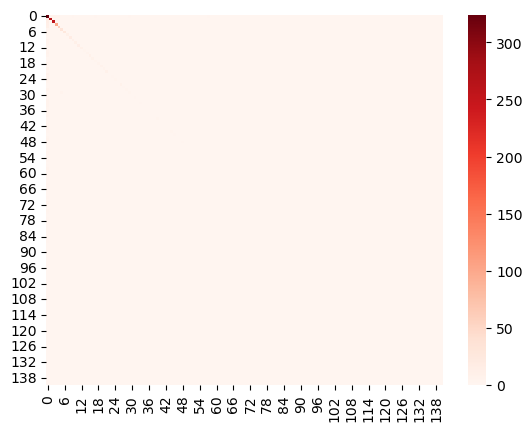

In [47]:
from sklearn.metrics import f1_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay
import seaborn as sns

y_true = np.argmax(y_val, axis=1)
y_pred = model.predict(X_val)

y_pred_dense = np.argmax(y_pred, axis=1)
#f1 = f1_score(y_true, y_pred_dense, average='weighted')
accuracy = accuracy_score(y_true, y_pred_dense)
#recall = recall_score(y_true, y_pred_dense)

convergence = history.history['loss'][-1]

#Plot confusion matrics
cm = confusion_matrix(y_true, y_pred_dense)
sns.heatmap(cm, fmt='', cmap='Reds')

In [48]:
print(f"accuracy: {round (100* accuracy, 2)}, convergence : {round(convergence, 4)}")

accuracy: 76.91, convergence : 0.08
